## Setup the environment

In [2]:
library(corrplot)
library(ape)
library(ggplot2)
options(repr.plot.width=12, repr.plot.height = 10)
library(dplyr)
source("baypass_utils.R")

corrplot 0.92 loaded


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Load the `baypass` results file (xxx.out) and name the rows/columns by population

In [3]:
# Read omega matrix BayPass output
bft.omega=as.matrix(read.table("bft_mat_omega.out"))

popnames <- c("BRZ", "KEY","MRT","PNS","PR","SCA","TX","VZ")
colnames(bft.omega) <- popnames
rownames(bft.omega) <- popnames

Create a correlation matrix of the omega values, which can be used to assess genomic differentiation between pools

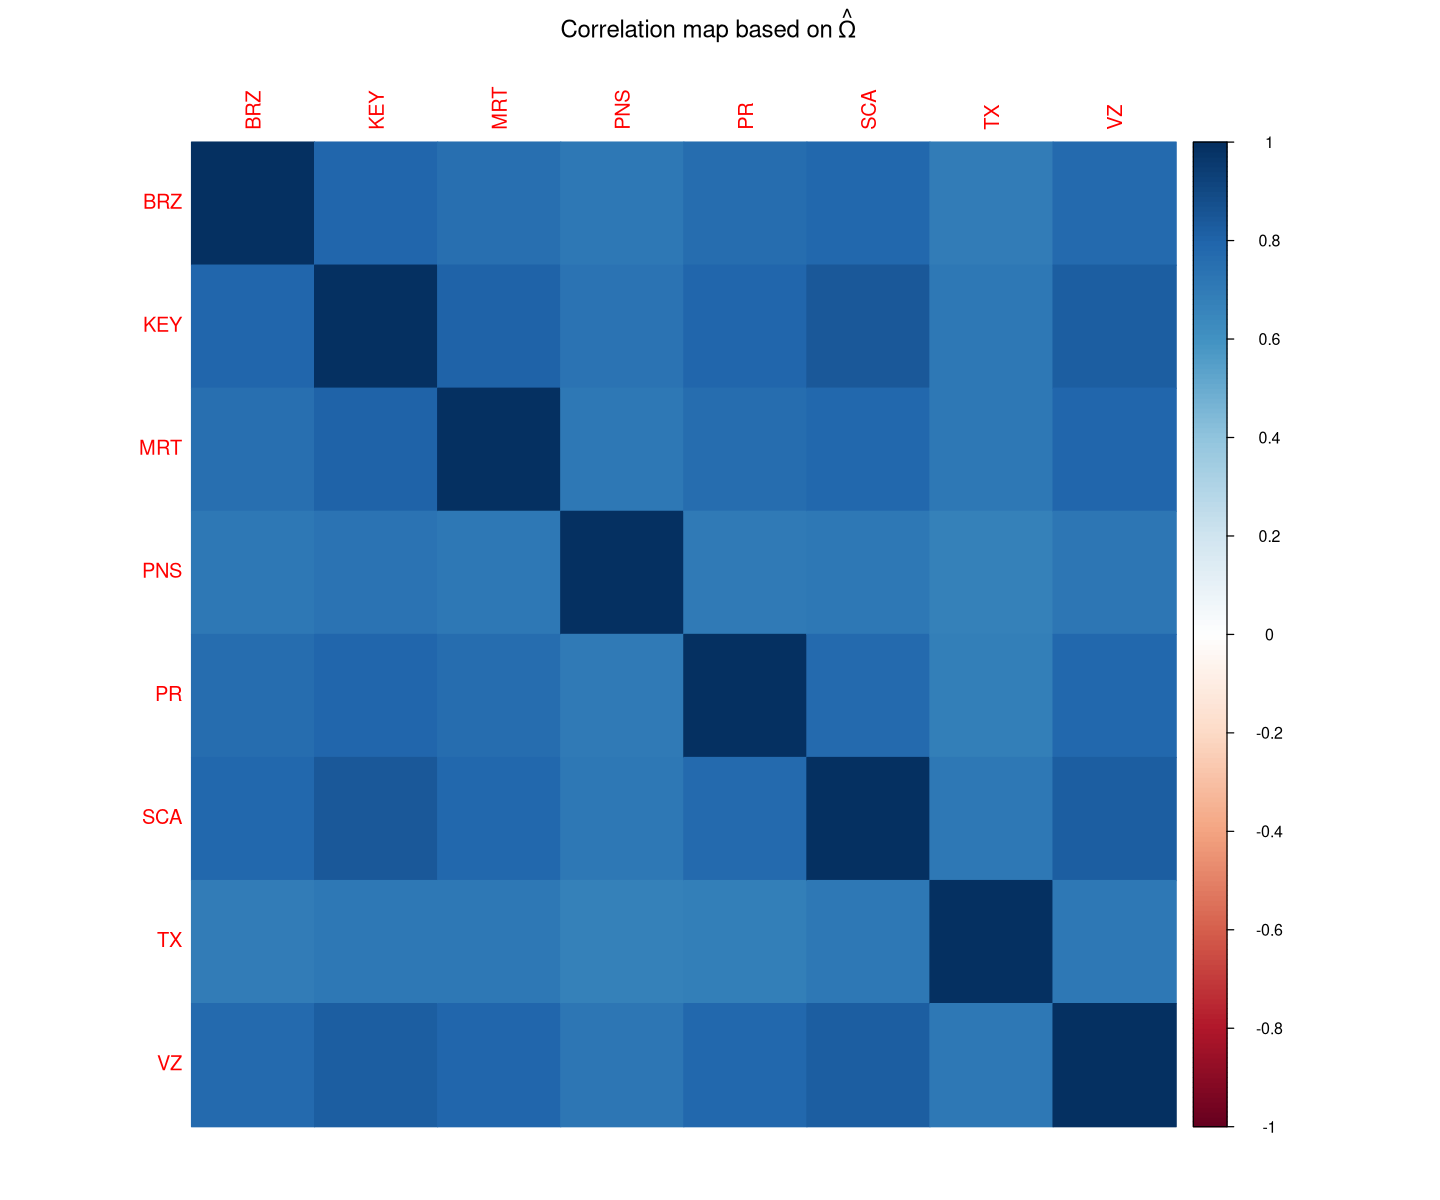

In [4]:
cor.mat <- cov2cor(bft.omega)
corrplot(
  cor.mat,method="color",mar=c(2,1,2,2)+0.1,
  main=expression("Correlation map based on"~hat(Omega))
)

Plot it as a hierarchical tree

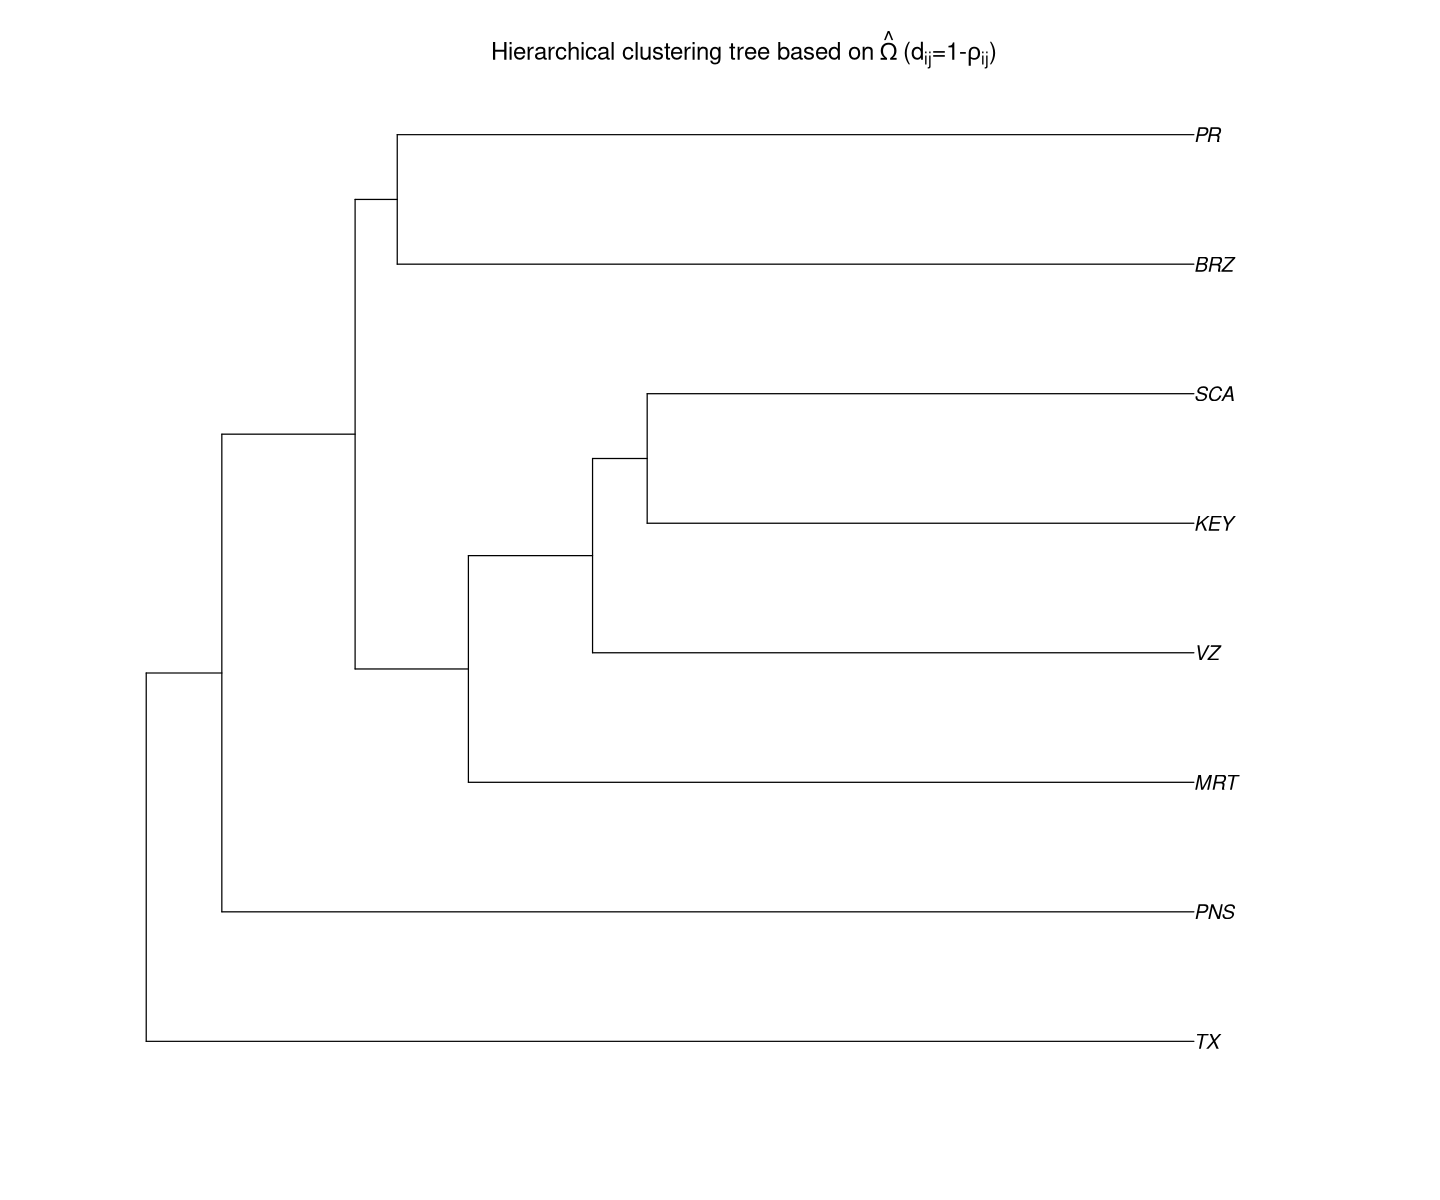

In [5]:
#plot as hierarchical tree
bft.tree <- as.phylo(hclust(as.dist(1-cor.mat**2)))
plot(
  bft.tree,type="p",
  main=expression("Hierarchical clustering tree based on"~hat(Omega)~"("*d[ij]*"=1-"*rho[ij]*")")
)

# Assess significance

Create simulated data from the existing data. This will be used to get a significance threshold later.

In [6]:
# Read the xtx BayPass output
snp.res <- read.table("bft_summary_pi_xtx.out", h=T)

# Get the Pi Beta distribution for POD generation
pi.beta.coef <- read.table("bft_summary_beta_params.out", h=T)$Mean

# Upload original data to get read counts
bft.data <- geno2YN("../../data/bft.kinless.baypass")

# create simulated data
bft.sims <- simulate.baypass(
  omega.mat=bft.omega,nsnp=10000,sample.size=bft.data$NN,
  beta.pi=pi.beta.coef,pi.maf=0,suffix="bft.BP.sim"
)

Loading required package: mvtnorm



1000 SNP simulated out of 10000 
2000 SNP simulated out of 10000 
3000 SNP simulated out of 10000 
4000 SNP simulated out of 10000 
5000 SNP simulated out of 10000 
6000 SNP simulated out of 10000 
7000 SNP simulated out of 10000 
8000 SNP simulated out of 10000 
9000 SNP simulated out of 10000 
10000 SNP simulated out of 10000 


Read the new omega matrix and compare to original.  You want similar values between the two

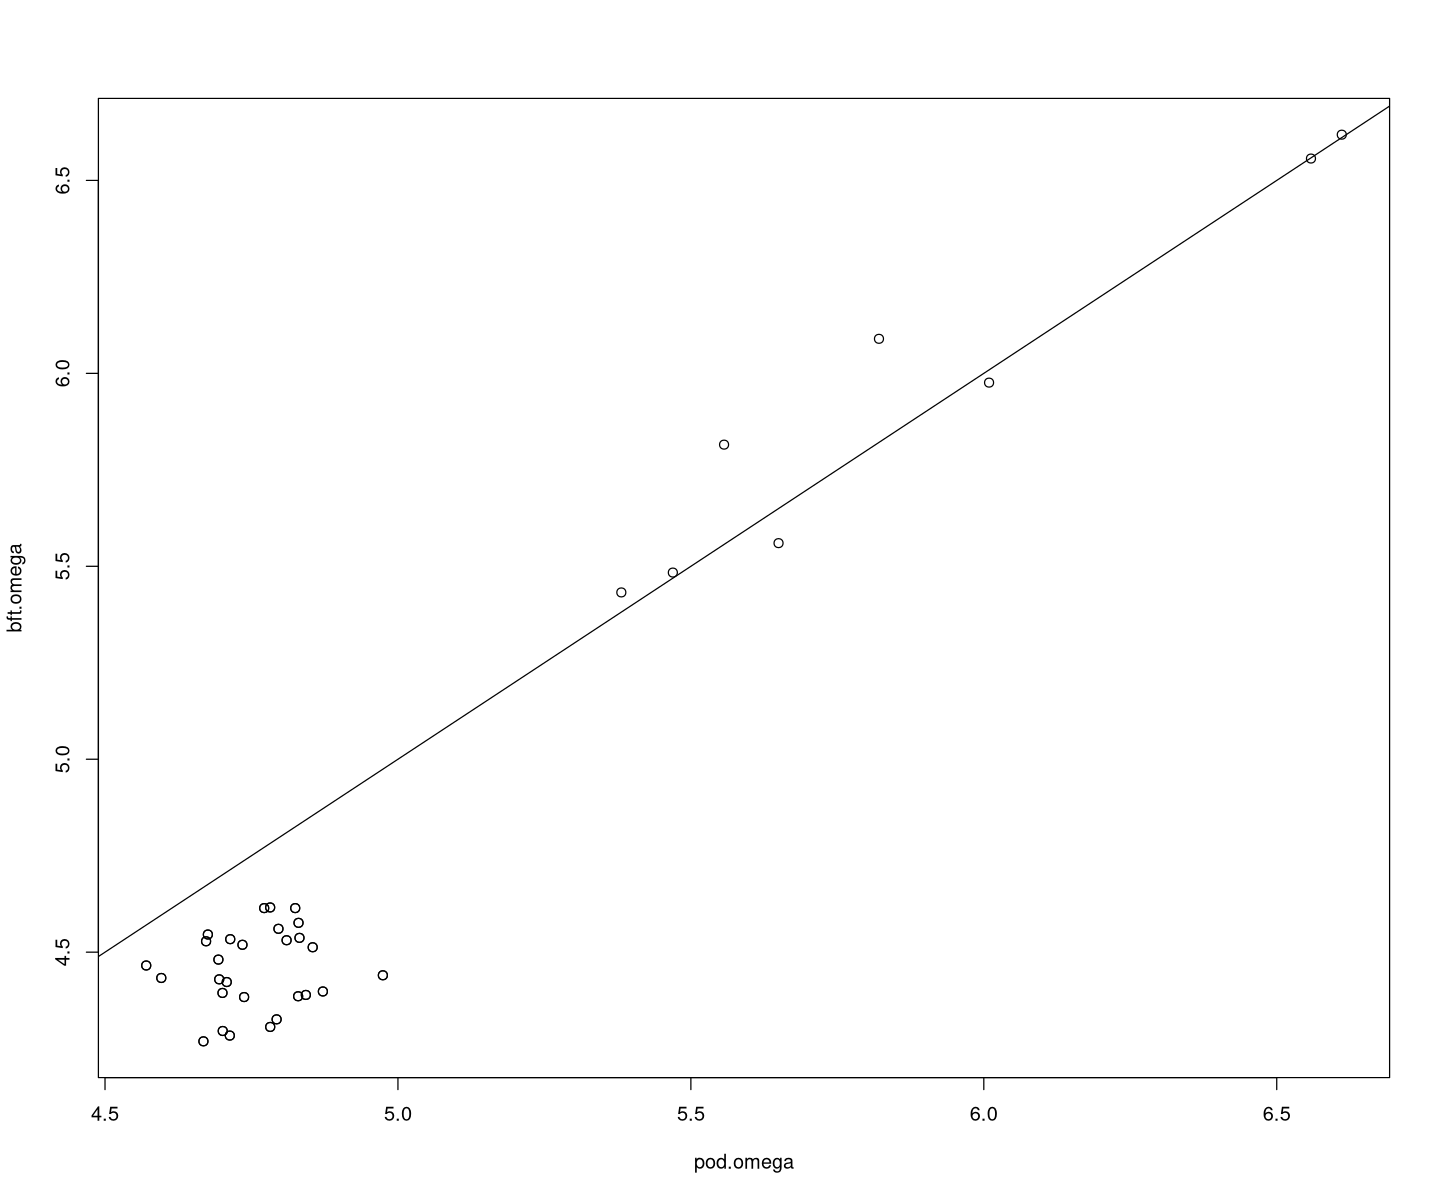

In [7]:
pod.omega=as.matrix(read.table("sims_mat_omega.out"))
plot(pod.omega,bft.omega) ; abline(a=0,b=1)

Get the Forstner and Moonen Distance (FMD) between simulated and original posterior estimates (here a smaller value is better) 

In [8]:
fmd.dist(pod.omega,bft.omega)

Loading required package: geigen



[1] 0.74532

Look at POD xtx values, and identify SNPs where the xtx values are above the 99% significance threshold from the POD. So in the plot, it is those loci (dots) which are above the abline

In [9]:
pod.xtx <- read.table("sims_summary_pi_xtx.out",h=T)$M_XtX
pod.thresh <- quantile(pod.xtx,probs=0.99)
pod.thresh

99% 
13.00296

Obtain the xtx threshold. Any SNPs with an xtx value greater than this are identified as outlier SNPs

[1] 88

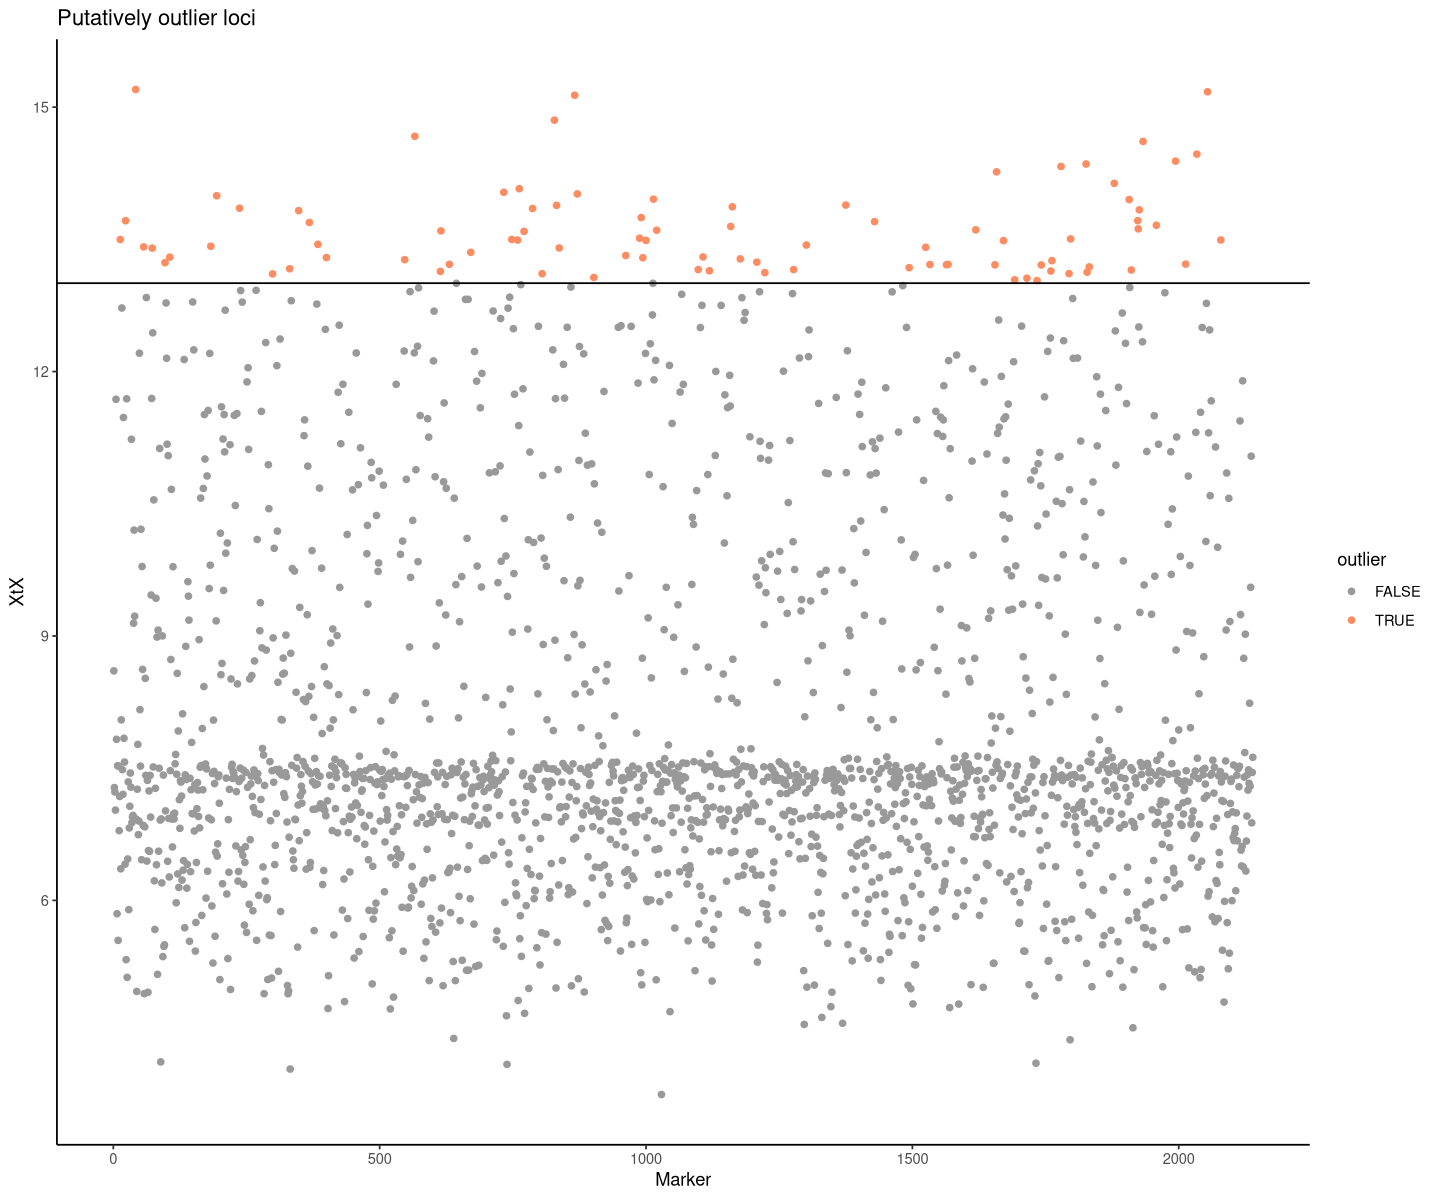

In [10]:
snp.scores <- data.frame(snp_idx = 1:length(snp.res$M_XtX), M_XtX = snp.res$M_XtX, outlier = snp.res$M_XtX > pod.thresh)
sum(snp.scores$outlier == T)
ggplot(snp.scores, aes(x = snp_idx, y = M_XtX)) +
    geom_point(aes(color = outlier)) +
    geom_hline(yintercept = pod.thresh) +
    xlab("Marker") +
    ylab("XtX") +
    labs(title = "Putatively outlier loci") +
    theme_classic() +
3    scale_color_manual(values = c("grey60", "#FC8D62"))

# Isolate putative outlier loci

In [14]:
putative_outliers <- snp.scores[snp.scores$outlier,]
putative_outliers

write.csv(putative_outliers, file = "bft.baypass.outliers", row.names = F, quote = F)

,snp_idx,M_XtX,outlier
,<int>,<dbl>,<lgl>
13,13,13.49756,TRUE
23,23,13.71134,TRUE
42,42,15.19982,TRUE
57,57,13.41410,TRUE
73,73,13.40033,TRUE
97,97,13.23530,TRUE
106,106,13.29781,TRUE
183,183,13.42157,TRUE
194,194,13.99448,TRUE
